## Autoencoder simples CONV para deteção de anomalias, neste caso para deteção de imagens que não pertencem o MNIST dataset


## imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
    
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.utils import save_image, make_grid

from torchinfo import summary

In [ ]:
#Constants

#path para guardar o dataset
PATH = './'
PATH_TRAIN = './mnist_train.csv'
PATH_TEST = './mnist_test.csv'

BATCH_SIZE = 128

In [ ]:
#device management 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados.

In [ ]:
#buscar o dataset utilizando os CSVs e uma classe para o dataset

# definição classe para o dataset
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path_train, path_test):
        # ler o ficheiro csv para um dataframe
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        # separar os inputs e os outputs
        self.x_train = df_train.values[:, 1:]
        self.x_train = self.x_train.reshape(len(self.x_train), 1, 28, 28)
        xmax, xmin = self.x_train.max(), self.x_train.min()
        self.x_train  = (self.x_train - xmin)/(xmax - xmin)
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        self.x_test = self.x_test.reshape(len(self.x_test), 1, 28, 28)
        xmax, xmin = self.x_test.max(), self.x_test.min()
        self.x_test  = (self.x_test - xmin)/(xmax - xmin)
        self.y_test = df_test.values[:, 0]
        # garantir que os inputs e labels sejam floats
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')
        #print(self.x_train.shape)
        #print(self.y_train.shape)
        #print(self.x_train)
        #print(self.y_train)
        
    # numero de casos de treino no dataset
    def __len_train__(self):
        return len(self.x_train)
     # numero de casos de teste no dataset
    def __len_test__(self):
        return len(self.x_test)
    
    # retornar um caso
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]
     # retornar um caso
    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    # retornar indeces para casos de treino de de teste em formato flat (vetor)
    def get_splits(self):
        x_train  = torch.from_numpy(np.array(self.x_train))
        y_train  = torch.from_numpy(np.array(self.y_train))
        x_test  = torch.from_numpy(np.array(self.x_test))
        y_test  = torch.from_numpy(np.array(self.y_test))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        test = torch.utils.data.TensorDataset(x_test,y_test)
        return train, test 

# preparar o dataset
def prepare_data_flat(path_train, path_test):
    # criar uma instancia do dataset
    dataset = CSVDataset(path_train, path_test)
    # calcular split
    train, test = dataset.get_splits()
    # preparar data loaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True) #32 len(train)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

# preparar os dados
train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


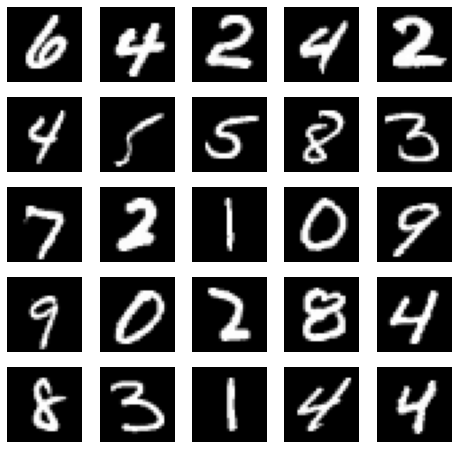

In [ ]:
#Visualização das imagens

def visualize_mnist_images_flat(dl):
    # get one batch of images
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    #inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    print(inputs.shape)
    # plot some images
    plt.figure(figsize=(8,8))
    for i in range(25):
        # define subplot

        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(b=None)
        # plot raw pixel data
        plt.imshow(inputs[i][0], cmap='gray')
    # show the figure
    plt.show()

visualize_mnist_images_flat(test_dl)

## 3. Ler o modelo previamente treinado em "aula3.1.2_pytorch_AE_CONV_treino_MNIST.ipynb"

In [ ]:
import models_mnist #modulo python com os modelos       
    
# definir a rede neuronal
#model = models_mnist.autoencoderCONV() #1.079/1.082
model = models_mnist.AE_CONV() #0.97/0.98

# ler o modelo
SAVED_MODEL = 'AE_CONV_MNIST.pth'
model= torch.load(SAVED_MODEL)
model.eval()
#visualizar a rede
print(summary(model, input_size=(BATCH_SIZE,  1,28,28), verbose=0)) #verbose=2 Show weight and bias layers in full detail
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [128, 1, 3, 3]            --
|    └─Conv2d: 2-1                       [128, 128, 22, 22]        6,400
|    └─BatchNorm2d: 2-2                  [128, 128, 22, 22]        256
|    └─ReLU: 2-3                         [128, 128, 22, 22]        --
|    └─MaxPool2d: 2-4                    [128, 128, 11, 11]        --
|    └─Conv2d: 2-5                       [128, 64, 9, 9]           73,792
|    └─BatchNorm2d: 2-6                  [128, 64, 9, 9]           128
|    └─ReLU: 2-7                         [128, 64, 9, 9]           --
|    └─MaxPool2d: 2-8                    [128, 64, 4, 4]           --
|    └─Conv2d: 2-9                       [128, 1, 3, 3]            257
|    └─BatchNorm2d: 2-10                 [128, 1, 3, 3]            2
|    └─ReLU: 2-11                        [128, 1, 3, 3]            --
├─Sequential: 1-2                        [128, 1, 28, 28]          --
|    └

AE_CONV(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 1, kernel_size=(2, 2), stride=(1, 1))
    (9): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 128, kernel_size=(7, 7), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05

## 4. Usar o Autoencoder.

shape:(28, 28)
img.shape: torch.Size([1, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.float32
img_anomaly.shape: torch.Size([1, 1, 28, 28])
pred_img_anomaly.shape: torch.Size([1, 1, 28, 28])
Distancia de não digito: 22.62271
pred_img_list.shape: torch.Size([1, 28, 28])
Distancia de  digito1: 4.2743745


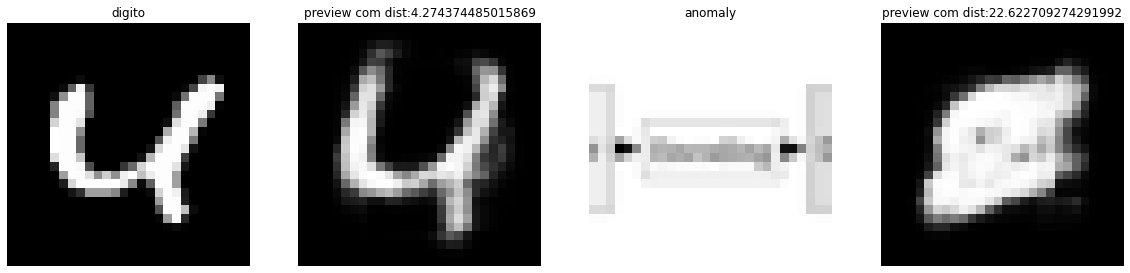

In [ ]:
#Podemos utilizar este modelo para deteção de anomalias (imagens que não são digitos)

# Process our image
def process_image(image_path,w,h):
    img = Image.open(image_path)
    width, height = img.size
    #print(f'width:{width}  height:{height}')
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((w, int(h*(height/width))) if width < height else (int(w*(width/height)), h))
    # Get the dimensions of the new image size
    width, height = img.size
    #print(f'width:{width}  height:{height}')
    # Set the coordinates to do a center crop of w x h
    left = (width - w)/2
    top = (height - h)/2
    right = (width + w)/2
    bottom = (height + h)/2
    img = img.crop((left, top, right, bottom))
    img = ImageOps.grayscale(img)
    # Turn image into numpy array
    img = np.array(img)
    print(f'shape:{img.shape}')
    # Make all values between 0 and 1
    xmax, xmin = img.max(), img.min()
    img  = (img - xmin)/(xmax - xmin)
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,np.newaxis,:]
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    #image=image.view(1,w*h) #fazer o flat do 28x28 para ficar como o mnist
    return image

def anomaly_detection(model, img_anomaly, img_list, idx): #img shape (784,1)
    print(img_list.shape)
    print(img_list.dtype) 
    img_list = img_list.to(device)
    img_anomaly= img_anomaly.to(device)   
    pred_img_anomaly,_ = model(img_anomaly)
    print(f'img_anomaly.shape: {img_anomaly.shape}')
    print(f'pred_img_anomaly.shape: {pred_img_anomaly.shape}')
    dist_pred_img = np.linalg.norm(img_anomaly[0].cpu().detach().numpy() - pred_img_anomaly[0].cpu().detach().numpy())  #Distancia de não digito: 22.185663
    print("Distancia de não digito:",dist_pred_img)    
    
    pred_img_list,_ = model(img_list)
    print(f'pred_img_list.shape: {pred_img_list[idx].shape}')
    dist_img1 = np.linalg.norm(img_list[idx].cpu().detach().numpy() - pred_img_list[idx].cpu().detach().numpy())  #Distancia de não digito: 22.185663
    print("Distancia de  digito1:",dist_img1)  

    pred_img_list = pred_img_list.view(pred_img_list.size(0), 1, 28, 28).cpu().data 
    pred_img_anomaly = pred_img_anomaly.view(pred_img_anomaly.size(0), 1, 28, 28).cpu().data
    
    
    img_anomaly = img_anomaly[0].reshape(1,28, 28).cpu()
    img1 = img_list[idx].reshape(1,28, 28).cpu()
    plt.subplots(1,4, figsize=(20, 10))
    plt.subplot(1,4,1)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('digito')
    plt.imshow(img1.permute((1, 2, 0)), cmap='gray')
    plt.subplot(1,4,2)
    plt.axis('off')
    plt.grid(b=None)
    plt.title(f'preview com dist:{dist_img1}')
    plt.imshow(pred_img_list[idx].permute((1, 2, 0)), cmap='gray')
    plt.subplot(1,4,3)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('anomaly')
    plt.imshow(img_anomaly.permute((1, 2, 0)), cmap='gray')
    plt.subplot(1,4,4)
    plt.axis('off')
    plt.grid(b=None)
    plt.title(f'preview com dist:{dist_pred_img}')
    plt.imshow(pred_img_anomaly[0].permute((1, 2, 0)), cmap='gray')
    plt.show()

#ANOMALIA = 'imagem_nao_digito.png'
#ANOMALIA = 'mnist_reconstruction_in.png'
ANOMALIA = 'ae_mlp.png'

img = process_image(ANOMALIA,28,28)
print(f'img.shape: {img.shape}')
_, (inputs, targets) = next(enumerate(test_dl))
# se a imagem imagem_nao_digito.png não for um digito do genero em que foi treinado então a distancia entre os dois vetores será muito grande.
anomaly_detection(model, img, inputs, 10) #receives an image tensor with shape (784,1)